# Experimentation using Generative Adversarial Networks

A **GAN** (Generative Adversarial Network) is a type of computer model used to create new images that look like real ones. It has two parts:

1. **Generator**: Makes new images.
2. **Discriminator**: Tries to tell if an image is real or fake.

The generator and discriminator work together. The generator gets better at making realistic images, and the discriminator gets better at spotting fakes. Over time, this process helps the GAN make images that look very real.

### Why use GAN for underwater image restoration?

Underwater images often have problems like:
- Blurry parts
- Strange colors
- Low contrast

These issues happen because of water particles and light scattering.

By using a GAN, the model can improve these bad images. The generator makes a clearer version of the image, and the discriminator helps it get better by checking if it looks realistic. Below we import some libraries to create our GAN and include some evaluation metrics.

In [1]:
import os
import torch
import torch.nn as nn
import torch.optim as optim
from utils.image_loader import LazyImageLoader
import matplotlib.pyplot as plt
from skimage.metrics import structural_similarity as compare_ssim
from tqdm import tqdm

## Generator Design

The Generator is a core component of the GAN, responsible for transforming underwater images into visually enhanced, clean images. It employs an encoder-decoder architecture, a popular choice for image-to-image translation tasks, which enables the model to learn spatial features and reconstruct high-quality images.

### Architecture
The Generator consists of two primary components:

1. **Encoder**  
   The encoder reduces the spatial dimensions of the input while capturing essential features. It achieves this through a series of convolutional layers that progressively downsample the image.  

   - **Layer 1:** Reduces the input image's 3 channels to 64 feature maps using a convolutional layer. A ReLU activation introduces non-linearity.
   - **Layer 2:** Expands the feature depth to 128, capturing more detailed spatial patterns.
   - **Layer 3:** Further increases the depth to 256 feature maps, allowing the model to focus on higher-level features.
   - **Layer 4:** Encodes the most complex features into 512 feature maps, significantly compressing the spatial dimensions.

2. **Decoder**  
   The decoder reconstructs the clean image from the encoder’s compressed representation. It uses transposed convolutional layers to progressively upsample the features and restore the original spatial resolution.  

   - **Layer 1:** Upsamples the 512 feature maps to 256 while refining the spatial details.
   - **Layer 2:** Further increases the resolution while reducing the depth to 128 feature maps.
   - **Layer 3:** Upsamples to 64 feature maps, preparing for the final reconstruction.
   - **Output Layer:** Restores the original 3-channel image using a transposed convolution with a Tanh activation, ensuring the output values are normalized between -1 and 1.

### Forward Pass
During the forward pass:
1. The input underwater image, with shape `(batch_size, 3, height, width)`, is passed through the encoder, compressing it into a smaller representation.
2. The encoded features are then fed into the decoder, which reconstructs the enhanced image.

The output of the generator has the same shape as the input, representing the restored clean image.

### Generator Initialization

Below, we define and initialize the Generator class.


In [2]:
class Generator(nn.Module):
    def __init__(self):
        """
        Initializes the Generator model.

        The Generator is designed to transform underwater images (input) 
        into clean images (output). It uses an encoder-decoder architecture, 
        where the encoder captures spatial features by downsampling, and the 
        decoder reconstructs the cleaned image by upsampling.
        """
        super(Generator, self).__init__()

        # Encoder: Downsamples the input image to a lower resolution.
        self.encoder = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=4, stride=2, padding=1),
            nn.ReLU(),
            nn.Conv2d(64, 128, kernel_size=4, stride=2, padding=1),
            nn.ReLU(),
            nn.Conv2d(128, 256, kernel_size=4, stride=2, padding=1),
            nn.ReLU(),
            nn.Conv2d(256, 512, kernel_size=4, stride=2, padding=1),
            nn.ReLU()
        )

        # Decoder: Upsamples the feature maps back to the original resolution.
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(512, 256, kernel_size=4, stride=2, padding=1),
            nn.ReLU(),
            nn.ConvTranspose2d(256, 128, kernel_size=4, stride=2, padding=1),
            nn.ReLU(),
            nn.ConvTranspose2d(128, 64, kernel_size=4, stride=2, padding=1),
            nn.ReLU(),
            nn.ConvTranspose2d(64, 3, kernel_size=4, stride=2, padding=1),
            nn.Tanh()
        )

    def forward(self, x):
        """
        Defines the forward pass of the Generator.
        
        Args:
            x (torch.Tensor): Input tensor representing an underwater image, 
                              with shape (batch_size, 3, height, width).
        
        Returns:
            torch.Tensor: Output tensor representing the restored clean image, 
                          with the same shape as the input.
        """
        x = self.encoder(x)
        x = self.decoder(x)
        return x


## Discriminator Design

The Discriminator is a critical component of the GAN, designed to evaluate the quality of images generated by the generator. Its role is to classify image pairs as either real (authentic, clean images) or fake (generated by the generator). This adversarial setup drives the generator to produce images that are increasingly indistinguishable from real ones.

### Input to the Discriminator
The Discriminator takes as input concatenated image pairs, consisting of:
- The underwater image (distorted)
- The corresponding clean or generated image (target or output)

These are represented as tensors of shape `(batch_size, 6, height, width)`, where the 6 channels include 3 for the underwater image and 3 for the clean/generated image.

### Architecture
The Discriminator employs a convolutional architecture to extract features and classify spatial regions of the input images. It uses a PatchGAN approach, which outputs predictions for overlapping spatial patches, rather than a single scalar value. This enables the model to focus on local structures and textures, ensuring detailed enhancements.

1. **Layer 1: Initial Feature Extraction**
   - A convolutional layer reduces the input tensor from 6 channels to 64 feature maps.
   - Uses a stride of 2 for spatial downsampling and a LeakyReLU activation to introduce non-linearity.

2. **Layer 2: Deeper Feature Extraction**
   - A second convolutional layer increases the depth to 128 feature maps.
   - Further spatial downsampling captures mid-level features of the input.

3. **Layer 3: Complex Features**
   - A third convolutional layer expands the depth to 256 feature maps.
   - This layer captures higher-level features and relationships within the image pairs.

4. **Layer 4: Final Downsampling**
   - A fourth convolutional layer increases the depth to 512 feature maps, representing the most complex features.
   - The spatial resolution is reduced further, enabling the network to focus on local regions.

5. **Output Layer**
   - A single convolutional layer reduces the depth to 1, producing a single-channel output feature map.
   - Each element of the output represents the Discriminator’s confidence (real or fake) for a corresponding spatial region of the input.

### Output of the Discriminator
The output is a tensor of shape `(batch_size, 1, reduced_height, reduced_width)`, where each value indicates the model's confidence that the corresponding spatial patch in the input image pair is real.

### Discriminator Initialization

Below, we define the Discriminator class and initialize its architecture.


In [3]:
class Discriminator(nn.Module):
    def __init__(self):
        """
        Initializes the Discriminator model.

        The Discriminator is designed to distinguish between real (clean) 
        and fake (generated) images. It uses a convolutional architecture to 
        classify input image pairs (underwater + clean) as real or fake.

        Input: Concatenated tensors of size (batch_size, 6, height, width),
               where 3 channels are for the underwater image and 3 are for
               the corresponding clean/generated image.
        Output: A single prediction score (real or fake) for each spatial region.
        """
        super(Discriminator, self).__init__()

        self.model = nn.Sequential(
            # Layer 1: Input is 6 channels (underwater + clean/generated image)
            nn.Conv2d(6, 64, kernel_size=4, stride=2, padding=1),  # Output: 128x128x64
            nn.LeakyReLU(0.2),

            # Layer 2: Further downsampling and feature extraction
            nn.Conv2d(64, 128, kernel_size=4, stride=2, padding=1),  # Output: 64x64x128
            nn.LeakyReLU(0.2),

            # Layer 3: Increase depth to capture complex features
            nn.Conv2d(128, 256, kernel_size=4, stride=2, padding=1),  # Output: 32x32x256
            nn.LeakyReLU(0.2),

            # Layer 4: Final downsampling step
            nn.Conv2d(256, 512, kernel_size=4, stride=2, padding=1),  # Output: 16x16x512
            nn.LeakyReLU(0.2),

            # Output layer: Single-channel feature map representing real/fake confidence
            nn.Conv2d(512, 1, kernel_size=4, stride=1, padding=1)  # Output: 15x15x1 (PatchGAN style)
        )

    def forward(self, x):
        """
        Defines the forward pass of the Discriminator.
        
        Args:
            x (torch.Tensor): Input tensor representing concatenated underwater 
                              and clean/generated image pairs, with shape 
                              (batch_size, 6, height, width).
        
        Returns:
            torch.Tensor: Output tensor of size (batch_size, 1, reduced_height, reduced_width),
                          where each element represents the Discriminator's confidence
                          that the corresponding spatial region is real.
        """
        return self.model(x)


## Model Initialization and Training Setup

### Models
- Generator: Transforms underwater images into clean, enhanced images using an encoder-decoder architecture.
- Discriminator: Distinguishes between real (clean) and fake (generated) image pairs using a convolutional architecture.

### Loss Functions
- Adversarial Loss: Binary cross-entropy loss with logits, used to train the Generator to produce realistic images and the Discriminator to differentiate between real and fake image pairs.
- Pixel-wise Loss: L1 loss, ensuring that generated images are close to the ground-truth clean images at a pixel level.

### Optimizers
- Generator Optimizer: Adam optimizer with a learning rate of 0.0002 and betas (0.5, 0.999) to ensure stable updates during training.
- Discriminator Optimizer: Similarly configured Adam optimizer for the Discriminator.

In [4]:
generator = Generator().cuda()
discriminator = Discriminator().cuda()

adversarial_loss = nn.BCEWithLogitsLoss()
pixel_loss = nn.L1Loss()

optimizer_G = optim.Adam(generator.parameters(), lr=0.0002, betas=(0.5, 0.999))
optimizer_D = optim.Adam(discriminator.parameters(), lr=0.0002, betas=(0.5, 0.999))

## Training Pipeline and Evaluation Metrics

This section describes the training process, including preprocessing, training steps for the Generator and Discriminator, and evaluation metrics.

### Preprocessing
- Input and ground-truth images are preprocessed by converting them to tensors and adding a batch dimension. This ensures compatibility with the models during training.
- The input image (underwater) and ground-truth image (clean) are expected to be of size \(256 \times 256\).

### Training Steps
1. **Discriminator Training:**
   - The Discriminator is trained to distinguish between real (clean) and fake (generated) image pairs.
   - Two types of losses are calculated:
     - Real loss: Discriminator's prediction on real image pairs (target label: 1).
     - Fake loss: Discriminator's prediction on generated image pairs (target label: 0).
   - The average of these losses is used to update the Discriminator's parameters.

2. **Generator Training:**
   - The Generator is trained to produce realistic images that can fool the Discriminator while being close to the ground-truth clean images.
   - Two losses are calculated:
     - Adversarial loss: Guides the Generator to produce images that the Discriminator classifies as real.
     - Pixel-wise loss: Ensures that the generated images are similar to the ground-truth clean images at a pixel level.
   - The combined loss is used to update the Generator's parameters.

### Evaluation Metrics
- PSNR (Peak Signal-to-Noise Ratio): Evaluates the quality of the generated images compared to the ground-truth clean images. Higher values indicate better image quality.
- SSIM (Structural Similarity Index): Measures structural similarity between the generated and ground-truth images, emphasizing perceived quality.

This setup ensures a systematic and detailed evaluation of the model's performance during training.

  0%|          | 0/10 [00:00<?, ?it/s]Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.13842218..0.11912193].


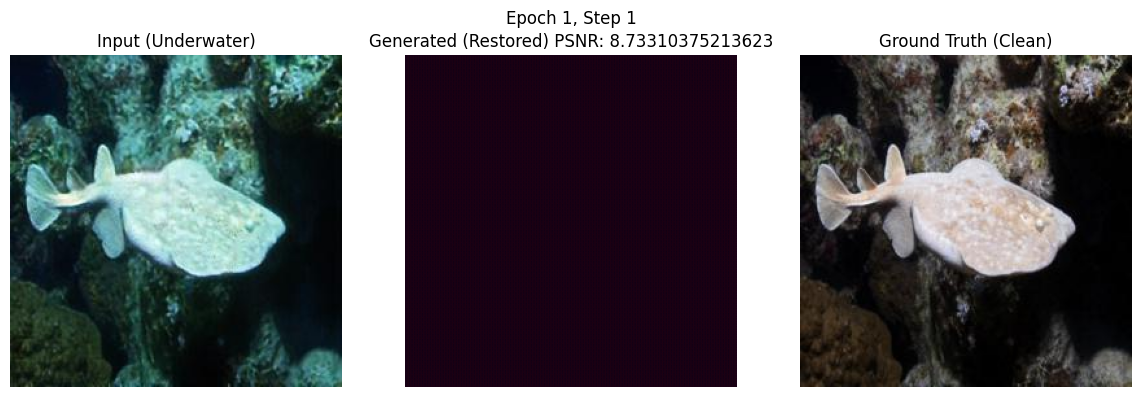

Epoch [1/10], Step [1/9250], D Loss: 0.6952, G Loss: 26.5524
Epoch [1/10], Step [1001/9250], D Loss: 0.6728, G Loss: 13.8727
Epoch [1/10], Step [2001/9250], D Loss: 0.6327, G Loss: 10.6407
Epoch [1/10], Step [3001/9250], D Loss: 0.3557, G Loss: 7.9584
Epoch [1/10], Step [4001/9250], D Loss: 0.1106, G Loss: 12.3285
Epoch [1/10], Step [5001/9250], D Loss: 0.0013, G Loss: 23.3276
Epoch [1/10], Step [6001/9250], D Loss: 0.0260, G Loss: 28.5991
Epoch [1/10], Step [7001/9250], D Loss: 0.2722, G Loss: 8.8859
Epoch [1/10], Step [8001/9250], D Loss: 0.6036, G Loss: 14.7509
Epoch [1/10], Step [9001/9250], D Loss: 0.0040, G Loss: 17.8382


 10%|█         | 1/10 [06:27<58:08, 387.58s/it]

Epoch [1/10] - Avg PSNR: 18.09, Min PSNR: 4.99, Max PSNR: 28.88
Epoch [1/10] - Avg SSIM: 0.5037, Min SSIM: -0.0936, Max SSIM: 0.8391
Saved best model with PSNR: 18.09
Epoch [2/10], Step [1/9250], D Loss: 2.6981, G Loss: 5.7762
Epoch [2/10], Step [1001/9250], D Loss: 0.5068, G Loss: 8.7732
Epoch [2/10], Step [2001/9250], D Loss: 0.5123, G Loss: 8.5543
Epoch [2/10], Step [3001/9250], D Loss: 0.8211, G Loss: 6.8250
Epoch [2/10], Step [4001/9250], D Loss: 0.0025, G Loss: 20.2322
Epoch [2/10], Step [5001/9250], D Loss: 0.0027, G Loss: 23.3047
Epoch [2/10], Step [6001/9250], D Loss: 0.1398, G Loss: 14.6363
Epoch [2/10], Step [7001/9250], D Loss: 0.1291, G Loss: 10.8761
Epoch [2/10], Step [8001/9250], D Loss: 0.4244, G Loss: 15.3251
Epoch [2/10], Step [9001/9250], D Loss: 0.0094, G Loss: 15.8601


 20%|██        | 2/10 [12:51<51:25, 385.68s/it]

Epoch [2/10] - Avg PSNR: 19.59, Min PSNR: 4.99, Max PSNR: 28.98
Epoch [2/10] - Avg SSIM: 0.6768, Min SSIM: -0.0936, Max SSIM: 0.9119
Saved best model with PSNR: 19.59
Epoch [3/10], Step [1/9250], D Loss: 3.1565, G Loss: 5.1553
Epoch [3/10], Step [1001/9250], D Loss: 0.6278, G Loss: 7.3206
Epoch [3/10], Step [2001/9250], D Loss: 0.4153, G Loss: 9.0664
Epoch [3/10], Step [3001/9250], D Loss: 0.7404, G Loss: 6.2937
Epoch [3/10], Step [4001/9250], D Loss: 0.0010, G Loss: 18.5825
Epoch [3/10], Step [5001/9250], D Loss: 0.0008, G Loss: 20.1506
Epoch [3/10], Step [6001/9250], D Loss: 0.0020, G Loss: 24.2160
Epoch [3/10], Step [7001/9250], D Loss: 0.1866, G Loss: 10.4117
Epoch [3/10], Step [8001/9250], D Loss: 0.2656, G Loss: 16.6958
Epoch [3/10], Step [9001/9250], D Loss: 0.0005, G Loss: 18.5482


 30%|███       | 3/10 [19:17<44:58, 385.56s/it]

Epoch [3/10] - Avg PSNR: 19.85, Min PSNR: 4.99, Max PSNR: 29.42
Epoch [3/10] - Avg SSIM: 0.7005, Min SSIM: -0.0936, Max SSIM: 0.9119
Saved best model with PSNR: 19.85
Epoch [4/10], Step [1/9250], D Loss: 4.9729, G Loss: 5.7788
Epoch [4/10], Step [1001/9250], D Loss: 0.6996, G Loss: 8.5405
Epoch [4/10], Step [2001/9250], D Loss: 0.3908, G Loss: 8.4445
Epoch [4/10], Step [3001/9250], D Loss: 0.7873, G Loss: 6.7661
Epoch [4/10], Step [4001/9250], D Loss: 0.0087, G Loss: 37.6105
Epoch [4/10], Step [5001/9250], D Loss: 0.0018, G Loss: 16.9711
Epoch [4/10], Step [6001/9250], D Loss: 0.0001, G Loss: 29.6341
Epoch [4/10], Step [7001/9250], D Loss: 0.2000, G Loss: 8.8080
Epoch [4/10], Step [8001/9250], D Loss: 0.3061, G Loss: 17.6373
Epoch [4/10], Step [9001/9250], D Loss: 0.0008, G Loss: 16.9057


 40%|████      | 4/10 [25:42<38:31, 385.27s/it]

Epoch [4/10] - Avg PSNR: 19.92, Min PSNR: 4.99, Max PSNR: 29.42
Epoch [4/10] - Avg SSIM: 0.7067, Min SSIM: -0.0936, Max SSIM: 0.9119
Saved best model with PSNR: 19.92
Epoch [5/10], Step [1/9250], D Loss: 5.1365, G Loss: 5.4119
Epoch [5/10], Step [1001/9250], D Loss: 0.6091, G Loss: 7.4825
Epoch [5/10], Step [2001/9250], D Loss: 0.4957, G Loss: 8.8308
Epoch [5/10], Step [3001/9250], D Loss: 0.5860, G Loss: 6.2659
Epoch [5/10], Step [4001/9250], D Loss: 0.5394, G Loss: 9.2757
Epoch [5/10], Step [5001/9250], D Loss: 0.0004, G Loss: 23.5776
Epoch [5/10], Step [6001/9250], D Loss: 0.0004, G Loss: 21.6829
Epoch [5/10], Step [7001/9250], D Loss: 0.1393, G Loss: 9.8511
Epoch [5/10], Step [8001/9250], D Loss: 0.1677, G Loss: 17.5775
Epoch [5/10], Step [9001/9250], D Loss: 0.0001, G Loss: 19.2665


 50%|█████     | 5/10 [32:06<32:05, 385.09s/it]Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.24530163..0.9719744].


Epoch [5/10] - Avg PSNR: 20.03, Min PSNR: 4.99, Max PSNR: 29.42
Epoch [5/10] - Avg SSIM: 0.7153, Min SSIM: -0.0936, Max SSIM: 0.9119
Saved best model with PSNR: 20.03


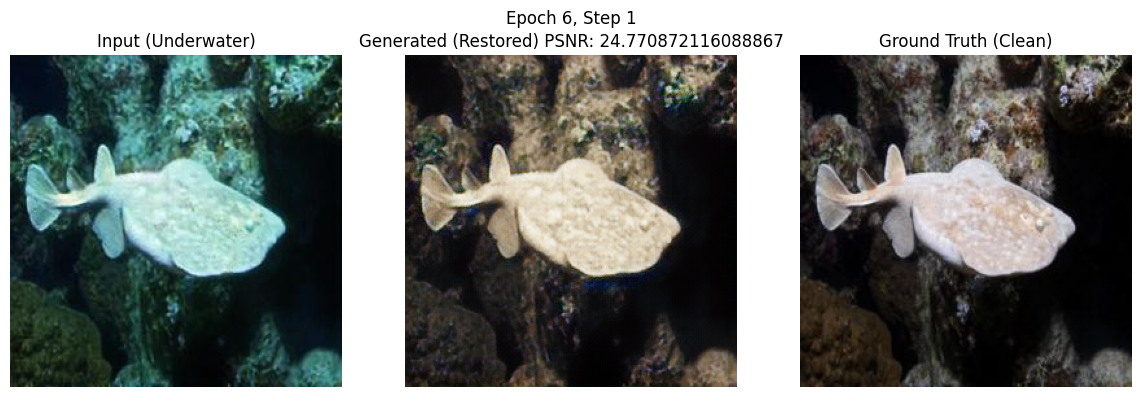

Epoch [6/10], Step [1/9250], D Loss: 6.4690, G Loss: 5.5704
Epoch [6/10], Step [1001/9250], D Loss: 0.4072, G Loss: 8.3509
Epoch [6/10], Step [2001/9250], D Loss: 0.4874, G Loss: 9.0340
Epoch [6/10], Step [3001/9250], D Loss: 0.5910, G Loss: 5.9587
Epoch [6/10], Step [4001/9250], D Loss: 0.0051, G Loss: 15.2393
Epoch [6/10], Step [5001/9250], D Loss: 0.0091, G Loss: 16.9331
Epoch [6/10], Step [6001/9250], D Loss: 0.0003, G Loss: 22.4951
Epoch [6/10], Step [7001/9250], D Loss: 0.1519, G Loss: 11.6703
Epoch [6/10], Step [8001/9250], D Loss: 0.2399, G Loss: 16.2600
Epoch [6/10], Step [9001/9250], D Loss: 0.0003, G Loss: 18.6521


 60%|██████    | 6/10 [38:32<25:40, 385.24s/it]

Epoch [6/10] - Avg PSNR: 20.10, Min PSNR: 4.99, Max PSNR: 29.42
Epoch [6/10] - Avg SSIM: 0.7206, Min SSIM: -0.0936, Max SSIM: 0.9119
Saved best model with PSNR: 20.10
Epoch [7/10], Step [1/9250], D Loss: 5.8022, G Loss: 5.9618
Epoch [7/10], Step [1001/9250], D Loss: 0.6206, G Loss: 7.6486
Epoch [7/10], Step [2001/9250], D Loss: 0.5395, G Loss: 8.5501
Epoch [7/10], Step [3001/9250], D Loss: 0.5261, G Loss: 5.3493
Epoch [7/10], Step [4001/9250], D Loss: 0.0003, G Loss: 16.7287
Epoch [7/10], Step [5001/9250], D Loss: 0.0021, G Loss: 25.0621
Epoch [7/10], Step [6001/9250], D Loss: 0.0003, G Loss: 24.1819
Epoch [7/10], Step [7001/9250], D Loss: 0.1813, G Loss: 10.5057
Epoch [7/10], Step [8001/9250], D Loss: 0.2912, G Loss: 17.6385
Epoch [7/10], Step [9001/9250], D Loss: 0.0001, G Loss: 20.6149


 70%|███████   | 7/10 [44:58<19:16, 385.49s/it]

Epoch [7/10] - Avg PSNR: 20.28, Min PSNR: 4.99, Max PSNR: 30.09
Epoch [7/10] - Avg SSIM: 0.7309, Min SSIM: -0.0936, Max SSIM: 0.9119
Saved best model with PSNR: 20.28
Epoch [8/10], Step [1/9250], D Loss: 7.2493, G Loss: 4.9011
Epoch [8/10], Step [1001/9250], D Loss: 0.6227, G Loss: 7.7752
Epoch [8/10], Step [2001/9250], D Loss: 0.3861, G Loss: 8.7248
Epoch [8/10], Step [3001/9250], D Loss: 0.7353, G Loss: 5.8643
Epoch [8/10], Step [4001/9250], D Loss: 0.0079, G Loss: 13.0741
Epoch [8/10], Step [5001/9250], D Loss: 0.0113, G Loss: 17.8403
Epoch [8/10], Step [6001/9250], D Loss: 0.0091, G Loss: 27.9444
Epoch [8/10], Step [7001/9250], D Loss: 0.3022, G Loss: 9.6532
Epoch [8/10], Step [8001/9250], D Loss: 0.2139, G Loss: 15.8773
Epoch [8/10], Step [9001/9250], D Loss: 0.0017, G Loss: 16.2728


 80%|████████  | 8/10 [51:31<12:55, 387.90s/it]

Epoch [8/10] - Avg PSNR: 20.23, Min PSNR: 4.99, Max PSNR: 30.09
Epoch [8/10] - Avg SSIM: 0.7322, Min SSIM: -0.0936, Max SSIM: 0.9119
Epoch [9/10], Step [1/9250], D Loss: 5.8727, G Loss: 5.7907
Epoch [9/10], Step [1001/9250], D Loss: 0.2526, G Loss: 8.2841
Epoch [9/10], Step [2001/9250], D Loss: 0.4934, G Loss: 9.2080
Epoch [9/10], Step [3001/9250], D Loss: 0.7378, G Loss: 6.3521
Epoch [9/10], Step [4001/9250], D Loss: 0.0001, G Loss: 25.8704
Epoch [9/10], Step [5001/9250], D Loss: 0.0050, G Loss: 28.1353
Epoch [9/10], Step [6001/9250], D Loss: 0.0001, G Loss: 24.7348
Epoch [9/10], Step [7001/9250], D Loss: 0.1926, G Loss: 10.6132
Epoch [9/10], Step [8001/9250], D Loss: 0.2706, G Loss: 16.5716
Epoch [9/10], Step [9001/9250], D Loss: 0.0001, G Loss: 19.8621


 90%|█████████ | 9/10 [58:01<06:28, 388.51s/it]

Epoch [9/10] - Avg PSNR: 20.31, Min PSNR: 4.99, Max PSNR: 30.09
Epoch [9/10] - Avg SSIM: 0.7352, Min SSIM: -0.0936, Max SSIM: 0.9119
Saved best model with PSNR: 20.31
Epoch [10/10], Step [1/9250], D Loss: 6.3570, G Loss: 5.1082
Epoch [10/10], Step [1001/9250], D Loss: 0.7052, G Loss: 8.4630
Epoch [10/10], Step [2001/9250], D Loss: 0.4868, G Loss: 8.3523
Epoch [10/10], Step [3001/9250], D Loss: 0.7890, G Loss: 5.6592
Epoch [10/10], Step [4001/9250], D Loss: 0.0009, G Loss: 15.2463
Epoch [10/10], Step [5001/9250], D Loss: 0.0005, G Loss: 20.9320
Epoch [10/10], Step [6001/9250], D Loss: 0.0001, G Loss: 25.9599
Epoch [10/10], Step [7001/9250], D Loss: 0.2014, G Loss: 12.1251
Epoch [10/10], Step [8001/9250], D Loss: 0.2497, G Loss: 16.1386
Epoch [10/10], Step [9001/9250], D Loss: 0.0003, G Loss: 18.5676


100%|██████████| 10/10 [1:04:27<00:00, 386.76s/it]

Epoch [10/10] - Avg PSNR: 20.45, Min PSNR: 4.99, Max PSNR: 30.09
Epoch [10/10] - Avg SSIM: 0.7429, Min SSIM: -0.0936, Max SSIM: 0.9119
Saved best model with PSNR: 20.45


In [5]:
from torchvision.transforms import ToTensor, Compose

def preprocess(image):
    """
    Preprocesses the input image by converting it to a tensor 
    and adding a batch dimension. Assumes the image is already 256x256.
    
    Args:
        image (PIL.Image): Input image (256x256).
    
    Returns:
        torch.Tensor: Preprocessed image tensor of shape (1, 3, 256, 256).
    """
    transform = Compose([ToTensor()])
    return transform(image).unsqueeze(0).cuda()

# PSNR Calculation
def calculate_psnr(fake, real):
    mse = torch.mean((fake - real) ** 2)
    psnr = 20 * torch.log10(1.0 / torch.sqrt(mse))
    return psnr.item()

# SSIM Calculation
def calculate_ssim(fake, real):
    fake_np = fake.squeeze().cpu().detach().numpy().transpose(1, 2, 0)
    real_np = real.squeeze().cpu().detach().numpy().transpose(1, 2, 0)
    ssim, _ = compare_ssim(fake_np, real_np, channel_axis=2, full=True, data_range=1.0)
    return ssim

def visualize_progress(input_image, generated_image, real_image, epoch, step):
    """
    Displays a side-by-side comparison of the input (underwater), 
    generated (restored), and real (ground truth) images.
    """
    psnr = calculate_psnr(generated_image, real_image)
    fig, axes = plt.subplots(1, 3, figsize=(12, 4))
    titles = ['Input (Underwater)', f'Generated (Restored) PSNR: {psnr}', 'Ground Truth (Clean)']
    images = [input_image.detach().cpu(), generated_image.detach().cpu(), real_image.detach().cpu()]
    for ax, img, title in zip(axes, images, titles):
        ax.imshow(img.squeeze().cpu().numpy().transpose(1, 2, 0))
        ax.set_title(title)
        ax.axis('off')
    plt.suptitle(f"Epoch {epoch + 1}, Step {step + 1}")
    plt.tight_layout()
    plt.show()

loader = LazyImageLoader(root='../data/EUVP/Paired')
num_epochs = 10
best_psnr = -float('inf')
min_psnr = float('inf')
max_psnr = -float('inf')
min_ssim = float('inf')
max_ssim = -float('inf')
psnr_epoch = 0.0
ssim_epoch = 0.0
save_path = './GAN_checkpoints'
os.makedirs(save_path, exist_ok=True)
image_limit = len(loader)

for epoch in tqdm(range(num_epochs)):
    psnr_epoch = 0
    ssim_epoch = 0
    
    for i in range(min(len(loader), image_limit)):
        imageA, imageB = loader[i]
        
        real_images = preprocess(imageB)  # Clean image
        input_images = preprocess(imageA)  # Underwater image
        
        # Train Discriminator
        optimizer_D.zero_grad()

        real_labels = torch.ones((real_images.size(0), 1, 15, 15)).cuda()
        fake_labels = torch.zeros((real_images.size(0), 1, 15, 15)).cuda()

        fake_images = generator(input_images)

        real_loss = adversarial_loss(discriminator(torch.cat([real_images, input_images], dim=1)), real_labels)
        fake_loss = adversarial_loss(discriminator(torch.cat([fake_images.detach(), input_images], dim=1)), fake_labels)
        d_loss = (real_loss + fake_loss) / 2

        d_loss.backward()
        optimizer_D.step()

        # Train Generator 
        optimizer_G.zero_grad()

        g_loss_adv = adversarial_loss(discriminator(torch.cat([fake_images, input_images], dim=1)), real_labels)

        g_loss_pix = pixel_loss(fake_images, real_images)

        g_loss = g_loss_adv + g_loss_pix * 100

        g_loss.backward()
        optimizer_G.step()

        # Calculate Metrics
        psnr = calculate_psnr(fake_images, real_images)
        ssim = calculate_ssim(fake_images, real_images)

        psnr_epoch += psnr
        ssim_epoch += ssim

        if i == 0 and epoch % 5 == 0:
            visualize_progress(
                input_images, fake_images, real_images,
                epoch=epoch, step=i
            )

        if i % 1000 == 0:
            print(f"Epoch [{epoch + 1}/{num_epochs}], Step [{i + 1}/{min(len(loader), image_limit)}], "
                  f"D Loss: {d_loss.item():.4f}, G Loss: {g_loss.item():.4f}")
            
        min_psnr = min(min_psnr, psnr)
        max_psnr = max(max_psnr, psnr)
        min_ssim = min(min_ssim, ssim)
        max_ssim = max(max_ssim, ssim)
        
    avg_psnr = psnr_epoch / len(loader)
    avg_ssim = ssim_epoch / len(loader)
    print(f"Epoch [{epoch + 1}/{num_epochs}] - Avg PSNR: {avg_psnr:.2f}, Min PSNR: {min_psnr:.2f}, Max PSNR: {max_psnr:.2f}")
    print(f"Epoch [{epoch + 1}/{num_epochs}] - Avg SSIM: {avg_ssim:.4f}, Min SSIM: {min_ssim:.4f}, Max SSIM: {max_ssim:.4f}")

    # Save model if PSNR improves
    if avg_psnr > best_psnr:
        best_psnr = avg_psnr
        torch.save(generator.state_dict(), os.path.join(save_path, 'best_generator.pth'))
        torch.save(discriminator.state_dict(), os.path.join(save_path, 'best_discriminator.pth'))
        print(f"Saved best model with PSNR: {best_psnr:.2f}")

- Below 20 dB: Very poor quality. The distortion is very noticeable.
- 20–25 dB: Poor quality. Some noticeable distortion, but not severely damaging.
- 25–30 dB: Fair quality. Slight distortion, but still visually acceptable.
- 30–40 dB: Good quality. The image is mostly indistinguishable from the original, with only very minor artifacts.
- Above 40 dB: Excellent quality. The reconstructed image is almost identical to the original, with virtually no visible distortion.-

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.082425535..0.9637127].


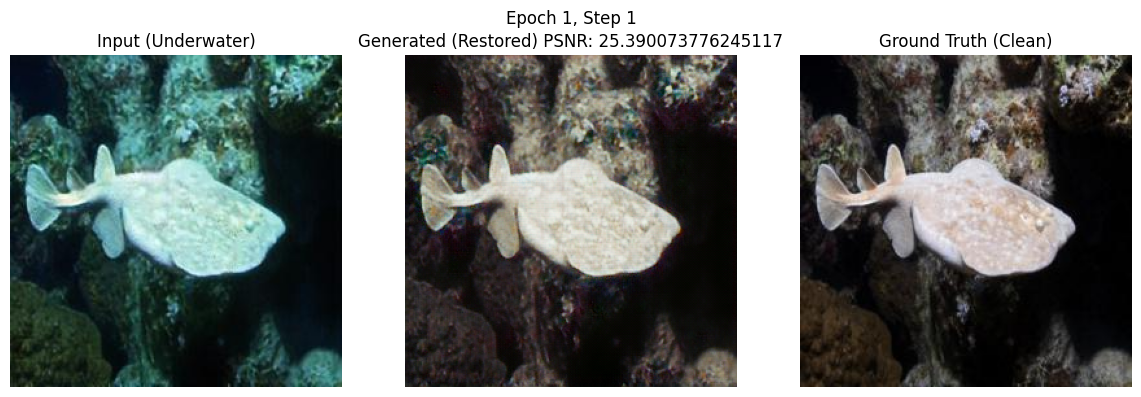

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.1830068..0.9698181].


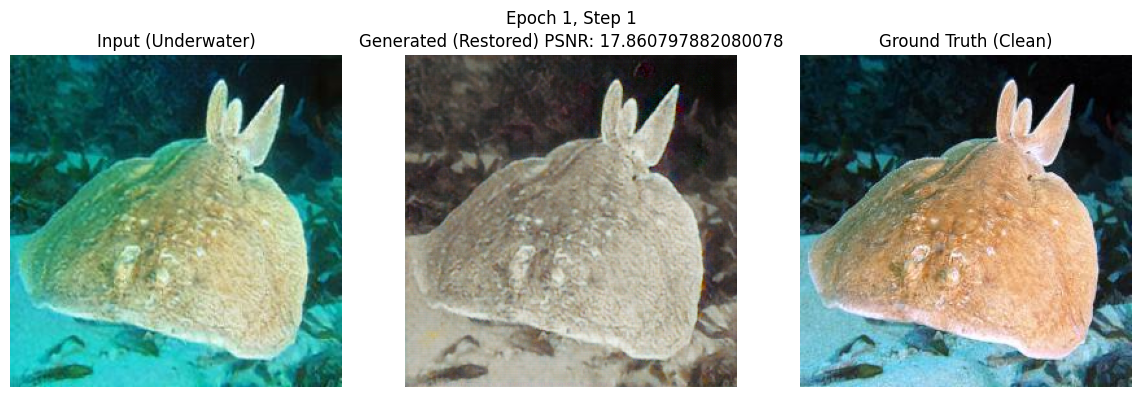

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.04505727..0.9323861].


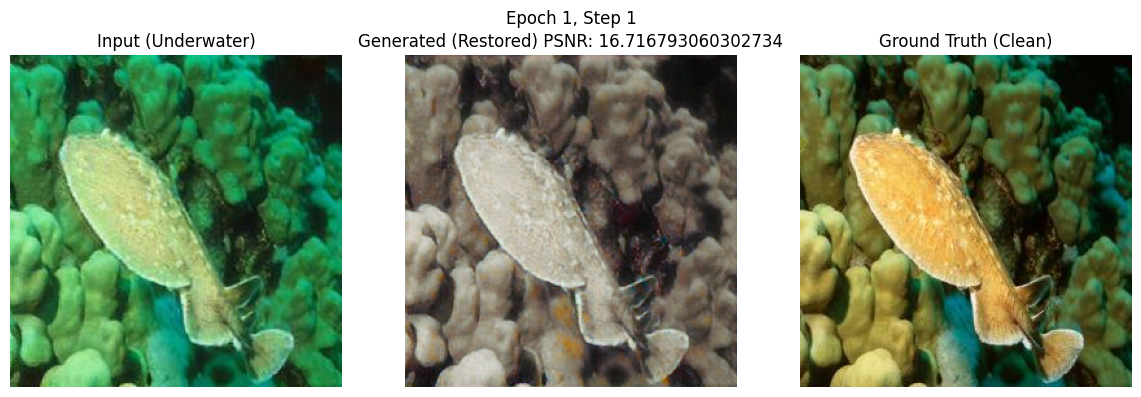

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.11872059..0.94631594].


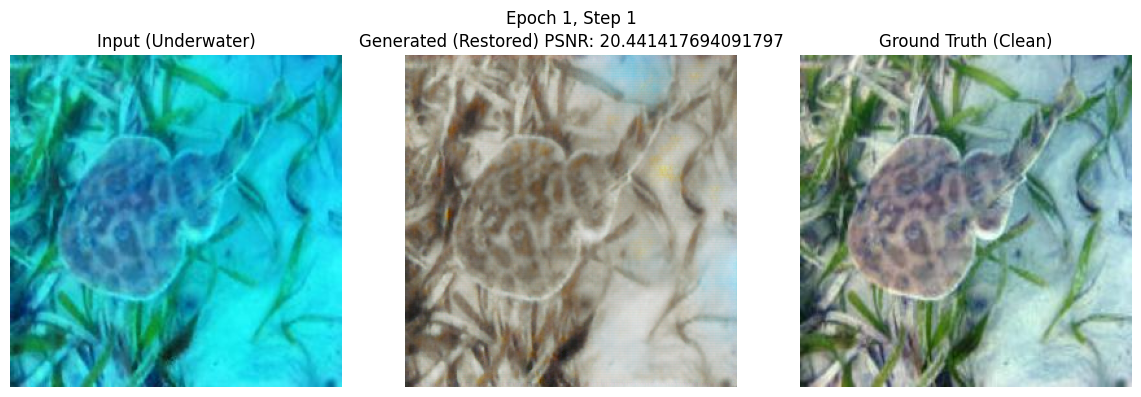

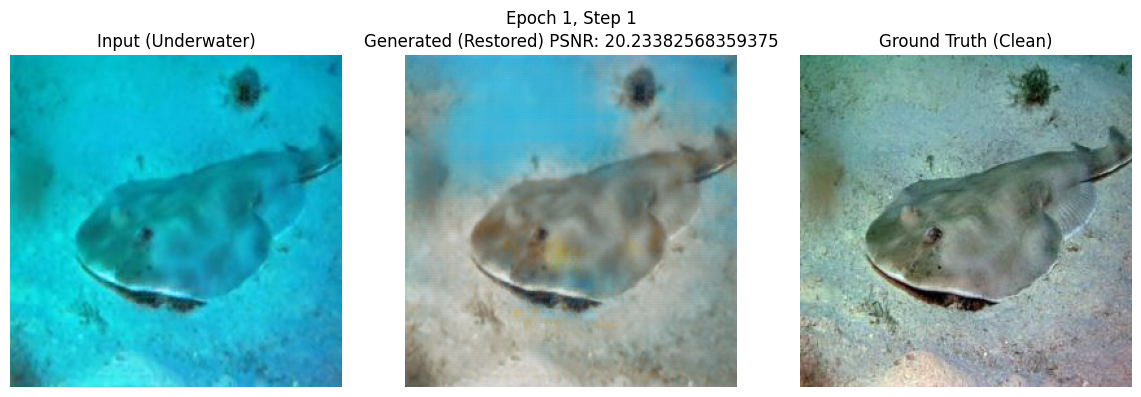

In [6]:
def visualize_progress(input_image, generated_image, real_image, epoch, step):
    """
    Displays a side-by-side comparison of the input (underwater), 
    generated (restored), and real (ground truth) images.
    """
    psnr = calculate_psnr(generated_image, real_image)
    fig, axes = plt.subplots(1, 3, figsize=(12, 4))
    titles = ['Input (Underwater)', f'Generated (Restored) PSNR: {psnr}', 'Ground Truth (Clean)']
    images = [input_image.detach().cpu(), generated_image.detach().cpu(), real_image.detach().cpu()]
    for ax, img, title in zip(axes, images, titles):
        ax.imshow(img.squeeze().cpu().numpy().transpose(1, 2, 0))
        ax.set_title(title)
        ax.axis('off')
    plt.suptitle(f"Epoch {epoch + 1}, Step {step + 1}")
    plt.tight_layout()
    plt.show()

with torch.no_grad():
    for i in range(5):
        imageA, imageB = loader[i]
        input_image = preprocess(imageA)
        clean_image = preprocess(imageB)
        restored_image = generator(input_image)
        
        visualize_progress(input_image, restored_image, clean_image, 0, 0)


The results of using the GAN to restore underwater images show both improvements and areas that need work. Here are the main points:

Input Images (Underwater): The original underwater images have common problems, like faded colors, blurriness, and low contrast. These problems happen because light behaves differently underwater, affecting the image quality.

Restoration Results: The middle images show the GAN's attempt to restore the images. The restoration makes the images clearer and sharper, but they still look quite different from the clean images on the right. One key issue is that the restored images often have a beige or brownish color, instead of the natural colors seen in the clean images.

Color Changes: A major difference in the restored images is the shift to more beige and brown tones. This makes the images look less realistic and natural compared to the original colors in the clean images. The model may be struggling to restore the colors correctly, possibly because it's hard to capture the right lighting and color balance in underwater photos.

Restoration Quality: The PSNR values show that the GAN improved the images by making them sharper and more detailed. However, the restored images still have noticeable differences from the clean ground truth images, especially in terms of color accuracy.

Room for Improvement: The beige and brownish tones suggest that the model needs more work, especially in restoring colors. With more training, the GAN could learn to handle color better and make the restored images look more realistic.

In conclusion, the GAN has made the underwater images clearer and sharper, but there are still problems with the colors. The images often look too beige or brown, which makes them less true to life. With more training, the model can improve in this area and create better results.